In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# reading the data into a dataframe and making a copy
df_pd = pd.read_csv("Dataset/bank-additional/bank-additional/bank-additional-full.csv", sep=";")
df = df_pd.copy()

In [67]:
# brief overview of the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Data Cleaning

1) Remove Duplicates

In [68]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())

12


In [69]:
# Remove duplicates
df = df.drop_duplicates()
df.shape # reduced to 41176 from 41188

(41176, 21)

2) Check and fix structural errors

In [70]:
# check unique values of categorical columns to identify structural errors
for x in df.select_dtypes("object").columns:
    print(x)
    print(df[x].unique())
    print(" ")    

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
 
marital
['married' 'single' 'divorced' 'unknown']
 
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
 
default
['no' 'unknown' 'yes']
 
housing
['no' 'yes' 'unknown']
 
loan
['no' 'yes' 'unknown']
 
contact
['telephone' 'cellular']
 
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
 
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
 
poutcome
['nonexistent' 'failure' 'success']
 
y
['no' 'yes']
 


No structural errors in the categorical features. The "unknown" label of some features and "nonexistent" label of poutcome will be handled later.

3) Filtering outliers

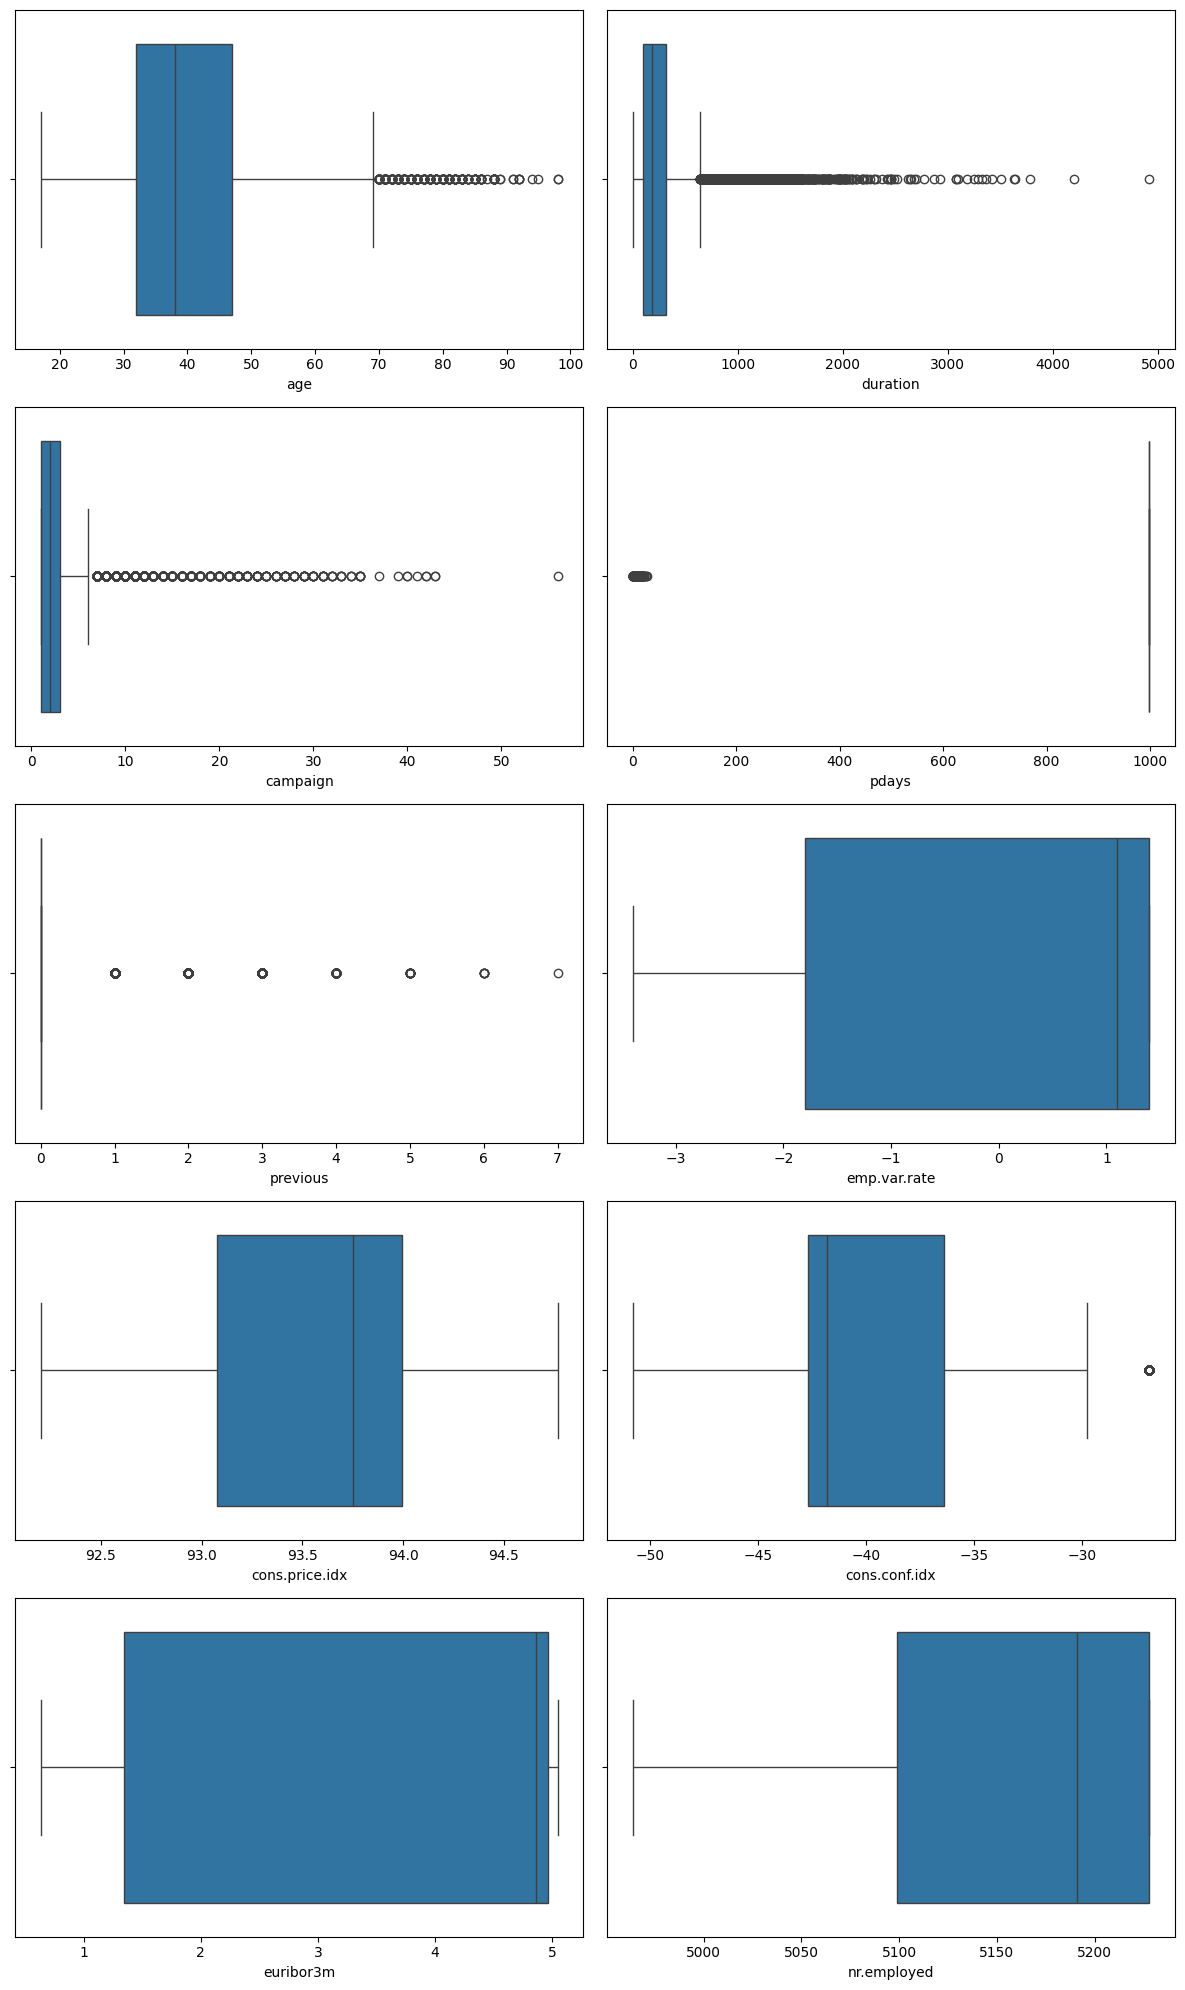

In [71]:
# check for outliers in numerical columns by plotting boxplots
numerical_columns = df.select_dtypes("number").columns
n_cols = 2
n_rows = len(numerical_columns) // n_cols

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df[col], ax=axes[i])

plt.tight_layout()
plt.show()

Outliers can be seen in age, duration, campaign, pdays, previous, cons.conf.idx

In [72]:
# Function to get outliers based on IQR
def get_outliers(series):
    Q1 = series.quantile(0.25)  # First quartile (25th percentile)
    Q3 = series.quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Count outliers
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return lower_bound, upper_bound, outliers

In [73]:
# outliers in age
print("Number of outliers in age :",get_outliers(df.age)[2])
# maximum age
print("Maximum age: ", df.age.max())

Number of outliers in age : 468
Maximum age:  98


Eventhough 468 values are outliers, these values are reasonable and valid. Therefore these values will be kept as they are.

In [74]:
# outliers in pdays
print("Percentage of clients not contacted previously: ",df[df['pdays'] == 999]['pdays'].shape[0]*100/df.shape[0])

Percentage of clients not contacted previously:  96.32067223625413


In [75]:
# outliers in previous
print("Percentage of zero previous contacts : ",df[df['previous'] == 0]['previous'].shape[0]*100/df.shape[0])

Percentage of zero previous contacts :  86.33912959005245


Further investigation reveals that clients not previously contacted according to 'pdays' has previous contacts according to 'previous'.

In [76]:
df[df['pdays'] == 999]['previous'].value_counts()

,count
previous,
0,35551
1,3696
2,349
3,50
4,12
5,2
6,1


The inconsistent rows will be removed to maintain data quality.

In [77]:
df = df[~((df['pdays'] == 999) & (df['previous'] > 0))]

'pdays' will be removed from the dataset as there is very little variation and not much information can be gained from it.

In [78]:
df.pdays.value_counts()/df.shape[0]*100

,count
pdays,
999,95.912696
3,1.184374
6,1.111531
4,0.318351
9,0.172665
2,0.164571
7,0.161873
12,0.156478
10,0.140290


In [79]:
df.drop(columns = 'pdays', inplace = True)

<ipython-input-79-c55254e8d955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = 'pdays', inplace = True)


Validating the "nonexistent" label of the 'poutcome' feature shows that for clients who were not contacted in previous marketing campaigns (previous = 0), the outcome of the previous campaign is consistently labeled as "nonexistent."

In [80]:
print(df.poutcome.value_counts(), "\n")

print(df[df['previous'] == 0]['poutcome'].value_counts())

poutcome
nonexistent    35551
success         1373
failure          142
Name: count, dtype: int64 

poutcome
nonexistent    35551
Name: count, dtype: int64


In [81]:
df.previous.value_counts()/df.shape[0]*100

,count
previous,
0,95.912696
1,2.333675
2,1.092646
3,0.447850
4,0.156478
5,0.043166
6,0.010792
7,0.002698


'previous' will be removed from the dataset as there is very little variation and not much information can be gained from it.

In [82]:
df.drop(columns = 'previous', inplace = True)

<ipython-input-82-278dda528f6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = 'previous', inplace = True)


In [83]:
# outliers in cons.conf.idx
print("Number of outliers in cons.conf.idx :",get_outliers(df["cons.conf.idx"])[2])
# maximum
print("Maximum cons.conf.idx value: ", df["cons.conf.idx"].max())
# upper bound
print("Upper bound: ", get_outliers(df["cons.conf.idx"])[1])

Number of outliers in cons.conf.idx : 348
Maximum cons.conf.idx value:  -26.9
Upper bound:  -26.949999999999992


In [84]:
# checking the outlier values
df[df["cons.conf.idx"] > get_outliers(df["cons.conf.idx"])[1]]["cons.conf.idx"].value_counts()

,count
cons.conf.idx,
-26.9,348


All the outliers have the value of -26.9 and they are all close to the upper bound(-26.9499999). Therefore it is not necesssary to handle those outliers.

In [85]:
# The duration is not known before a call is performed, therefore it is not used for model training
df.drop(columns = ["duration"], inplace = True)

<ipython-input-85-6f4799b02d63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ["duration"], inplace = True)


Campaign indicates the number of contacts performed during this campaign for a particular client.
The maximum value of campaign is 56 and the values above 6 are taken as outliers. These values cannot be dropped as they might not be erroneous. It is hard to reach an exact decision without more information about the feature, therefore by considering the boxplot the outliers were imputed with the median.

In [86]:
# outliers in campaign
print("Number of outliers in campaign :",get_outliers(df.campaign)[2])
# maximum
print("Maximum campaign value: ", df.campaign.max())
# upper bound
print("Upper bound: ", get_outliers(df.campaign)[1])

Number of outliers in campaign : 2318
Maximum campaign value:  56
Upper bound:  6.0


In [87]:
median = np.median(df['campaign'])
lower_bound, upper_bound, outliers = get_outliers(df['campaign'])

# Replace outliers in the 'campaign' column with the median
df.loc[(df['campaign'] < lower_bound) | (df['campaign'] > upper_bound), 'campaign'] = median

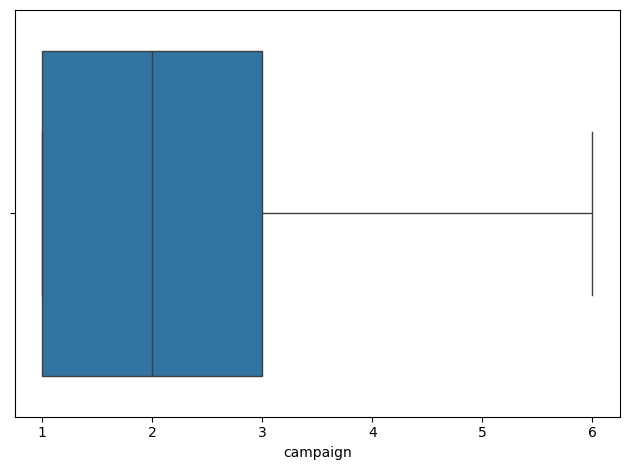

In [88]:
# outliers handled
sns.boxplot(x=df["campaign"])
plt.tight_layout()
plt.show()

4) Handle missing data

In [89]:
# Visualize the "unknown" value percentage of each column
unknownDF = pd.DataFrame({"Column": pd.Series(dtype="str"), "Unknown_Percentage": pd.Series(dtype="float")})
for x in df.columns:
    numberUnknown = df[x][df[x] == 'unknown'].shape[0]
    unknownProportion = numberUnknown/df.shape[0]
    # only non zero percentages are displayed
    if unknownProportion != 0:
        new_row = pd.DataFrame({"Column":[x], "Unknown_Percentage":[unknownProportion*100]})
        unknownDF = pd.concat([unknownDF, new_row], ignore_index=True)
unknownDF

,Column,Unknown_Percentage
0,job,0.844440
1,marital,0.180759
2,education,4.203313
3,default,21.812443
4,housing,2.387633
5,loan,2.387633


In [90]:
df.default.value_counts()

,count
default,
no,28979
unknown,8085
yes,2


Almost all values of the 'default' feature is either "no" or "unknown". This column does not give much information so it will be dropped.

In [91]:
# drop default column
df.drop(columns = ['default'], inplace = True)

In [92]:
# remove "unknown" rows from job column
df = df[df["job"] != "unknown"]

In [93]:
# remove "unknown" rows from marital column
df = df[df["marital"] != "unknown"]

In [94]:
# remove "unknown" rows from education column
df = df[df["education"] != "unknown"]

In [95]:
# remove "unknown" rows from housing column
df = df[df["housing"] != "unknown"]

In [96]:
# remove "unknown" rows from loan column
df = df[df["loan"] != "unknown"]

In [97]:
# class imbalance
class_counts = df['y'].value_counts()

# Display the counts and the ratio
print("Class counts:")
print(class_counts)
print(f"\nClass imbalance ratio: {class_counts.iloc[0]/df.shape[0]:.3f}: {class_counts.iloc[1]/df.shape[0]:.3f}")

Class counts:
y
no     30635
yes     3786
Name: count, dtype: int64

Class imbalance ratio: 0.890: 0.110


This class imbalance will be handled by using several techniques.

In [98]:
# Ensure y is encoded as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df.y = label_encoder.fit_transform(df.y)

In [99]:
# one hot encoding
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month','day_of_week','poutcome'], drop_first=True)

In [100]:
y = df.y
X = df.drop(columns = ['y'])

Model validation technique used will be stratified K fold cross validation as the dataset is imbalanced.

Class imbalance will be handled with different techniques when training models,


1.   Random Oversampling
2.   Random Undersampling
3.   SMOTE



Random Oversampling

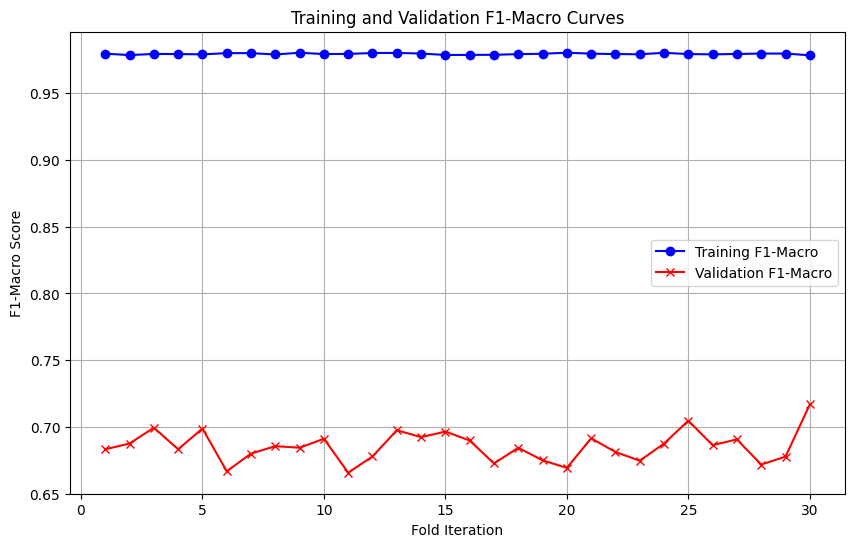

Mean Training F1-Macro: 0.980
Mean Validation F1-Macro: 0.685


In [101]:
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define pipeline
pipeline_steps = [('oversample', RandomOverSampler()), ('classifier', RandomForestClassifier())]
pipeline = Pipeline(steps=pipeline_steps)

# Define Repeated Stratified K-Fold
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Store training and validation scores
train_scores = []
val_scores = []

# Manually calculate training and validation performance for each fold
for train_idx, val_idx in cv_strategy.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Evaluate on training data (same data used for training)
    y_train_pred = pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data (held-out data)
    y_val_pred = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)

# Convert to numpy arrays for mean and std calculation
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')

In [102]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import pandas as pd

# Define your model
rf = RandomForestClassifier(random_state=42)

# Define your hyperparameter grid
param_grid = {
    'rf__n_estimators': [5, 9, 15],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scoring function for F1-Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Set up a pipeline with RandomOverSampler and RandomForestClassifier
pipeline = Pipeline(steps=[('ros', RandomOverSampler(random_state=42)),
                           ('rf', rf)])

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=f1_macro_scorer, return_train_score=True)

# Fit the grid search
grid_search.fit(X, y)  # Assuming X_train and y_train are your data

# Display the results: training and validation F1 scores for all combinations
results = pd.DataFrame(grid_search.cv_results_)

# Displaying only the relevant columns: params, mean_train_score, mean_test_score (validation score)
results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)


,params,mean_train_score,mean_test_score
40,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.714816,0.695532
38,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.713554,0.695334
28,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.715256,0.695047
34,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.715454,0.694861
53,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.709919,0.694441
35,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.713394,0.694407
41,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.713939,0.694229
29,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.713422,0.694130
52,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.708990,0.693960
37,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.712962,0.693690


The best model has,

*   max_depth: 10
*   min_samples_leaf: 2
*   min_samples_split: 5
*   n_estimators: 9

Mean Training F1-Macro: 0.71

Mean Validation F1-Macro: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      9191
           1       0.40      0.60      0.48      1136

    accuracy                           0.86     10327
   macro avg       0.67      0.75      0.70     10327
weighted avg       0.89      0.86      0.87     10327



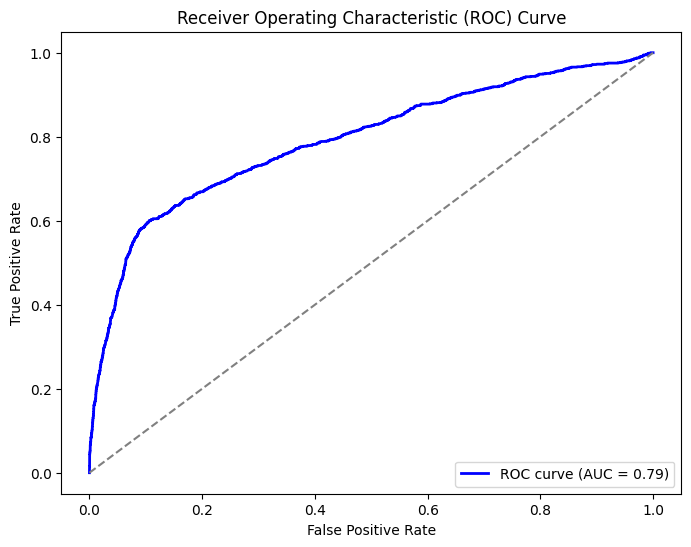

In [103]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Assuming you have your imbalanced dataset X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply RandomOverSampler to the training set only
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the model using the best parameters from grid search
best_model = grid_search.best_estimator_

# Fit the best model on the resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Get predicted labels and predicted probabilities for the positive class (class 1)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming class 1 is the positive class

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Random Undersampling

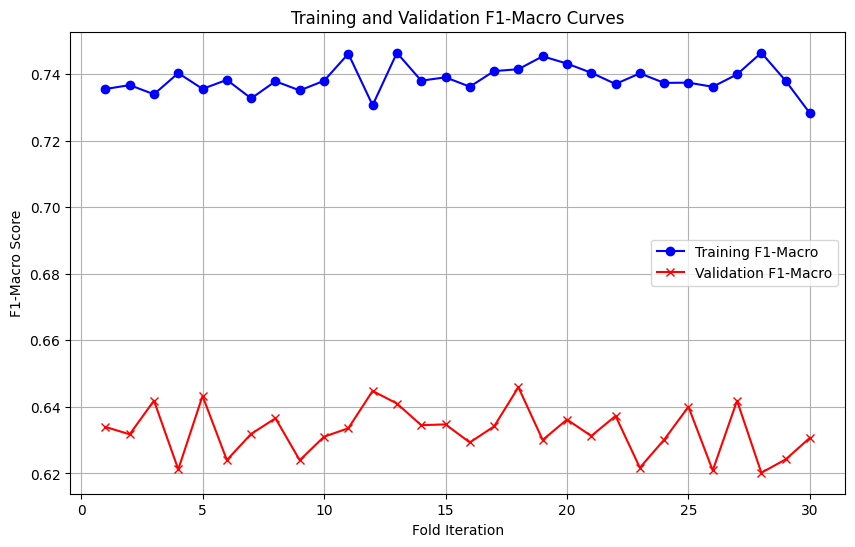

Mean Training F1-Macro: 0.738
Mean Validation F1-Macro: 0.633


In [104]:
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define pipeline
pipeline_steps = [('oversample', RandomUnderSampler()), ('classifier', RandomForestClassifier())]
pipeline = Pipeline(steps=pipeline_steps)

# Define Repeated Stratified K-Fold
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Store training and validation scores
train_scores = []
val_scores = []

# Manually calculate training and validation performance for each fold
for train_idx, val_idx in cv_strategy.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Evaluate on training data (same data used for training)
    y_train_pred = pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data (held-out data)
    y_val_pred = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)

# Convert to numpy arrays for mean and std calculation
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')

In [105]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
import pandas as pd

# Define your model
rf = RandomForestClassifier(random_state=42)

# Define your hyperparameter grid
param_grid = {
    'rf__n_estimators': [5, 9, 15],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scoring function for F1-Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Set up a pipeline with RandomOverSampler and RandomForestClassifier
pipeline = Pipeline(steps=[('ros', RandomUnderSampler(random_state=42)),
                           ('rf', rf)])

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=f1_macro_scorer, return_train_score=True)

# Fit the grid search
grid_search.fit(X, y)  # Assuming X_train and y_train are your data

# Display the results: training and validation F1 scores for all combinations
results = pd.DataFrame(grid_search.cv_results_)

# Displaying only the relevant columns: params, mean_train_score, mean_test_score (validation score)
results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
50,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.689132,0.681267
47,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.689132,0.681267
35,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.691121,0.680661
44,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.689897,0.679884
53,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.688769,0.679655
38,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.691018,0.679450
49,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.686855,0.679014
46,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.686855,0.679014
37,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.689067,0.678895
32,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.691683,0.678488


The best model has,

*   max_depth: 10
*   min_samples_leaf: 4
*   min_samples_split: 5
*   n_estimators: 15

Mean Training F1-Macro: 0.69

Mean Validation F1-Macro: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      9191
           1       0.35      0.63      0.45      1136

    accuracy                           0.83     10327
   macro avg       0.65      0.74      0.67     10327
weighted avg       0.88      0.83      0.85     10327



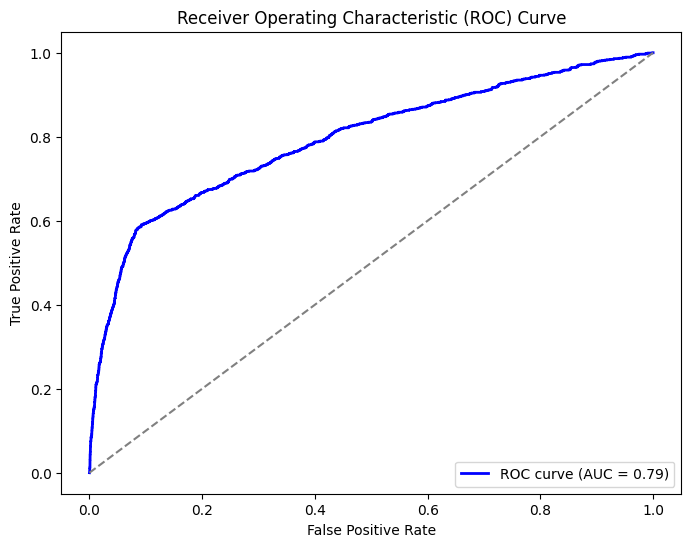

In [106]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Assuming you have your imbalanced dataset X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply RandomOverSampler to the training set only
ros = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the model using the best parameters from grid search
best_model = grid_search.best_estimator_

# Fit the best model on the resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Get predicted labels and predicted probabilities for the positive class (class 1)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming class 1 is the positive class

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


SMOTE

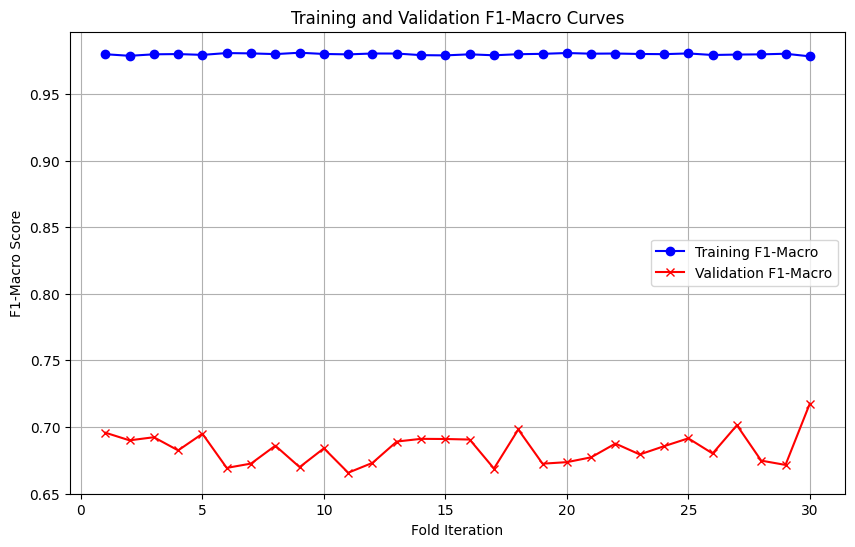

Mean Training F1-Macro: 0.980
Mean Validation F1-Macro: 0.684


In [107]:
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # Import SMOTE instead of RandomOverSampler
from sklearn.metrics import f1_score
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Define pipeline with SMOTE
pipeline_steps = [('oversample', SMOTE()), ('classifier', RandomForestClassifier())]  # Use SMOTE here
pipeline = Pipeline(steps=pipeline_steps)

# Define Repeated Stratified K-Fold
cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Store training and validation scores
train_scores = []
val_scores = []

# Manually calculate training and validation performance for each fold
for train_idx, val_idx in cv_strategy.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Evaluate on training data (same data used for training)
    y_train_pred = pipeline.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data (held-out data)
    y_val_pred = pipeline.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)

# Convert to numpy arrays for mean and std calculation
train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')


In [108]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE  # Use SMOTE instead of RandomOverSampler
from imblearn.pipeline import Pipeline
import pandas as pd

# Define your model
rf = RandomForestClassifier(random_state=42)

# Define your hyperparameter grid
param_grid = {
    'rf__n_estimators': [5, 9, 15],
    'rf__max_depth': [5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scoring function for F1-Macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Set up a pipeline with SMOTE and RandomForestClassifier
pipeline = Pipeline(steps=[('smote', SMOTE(random_state=42)),  # Replace RandomOverSampler with SMOTE
                           ('rf', rf)])

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring=f1_macro_scorer, return_train_score=True)

# Fit the grid search
grid_search.fit(X, y)  # Assuming X_train and y_train are your data

# Display the results: training and validation F1 scores for all combinations
results = pd.DataFrame(grid_search.cv_results_)

# Displaying only the relevant columns: params, mean_train_score, mean_test_score (validation score)
results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score
44,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.724488,0.711852
32,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.726414,0.711803
50,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.724260,0.711797
47,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.724260,0.711797
29,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.726604,0.711541
41,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.724311,0.711142
35,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.724487,0.710944
38,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.723901,0.710554
53,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.723195,0.709985
40,"{'rf__max_depth': 10, 'rf__min_samples_leaf': ...",0.722414,0.709880


The best model has,

*   max_depth: 10
*   min_samples_leaf: 2
*   min_samples_split: 10
*   n_estimators: 15

Mean Training F1-Macro: 0.72

Mean Validation F1-Macro: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      9191
           1       0.43      0.55      0.49      1136

    accuracy                           0.87     10327
   macro avg       0.69      0.73      0.71     10327
weighted avg       0.89      0.87      0.88     10327



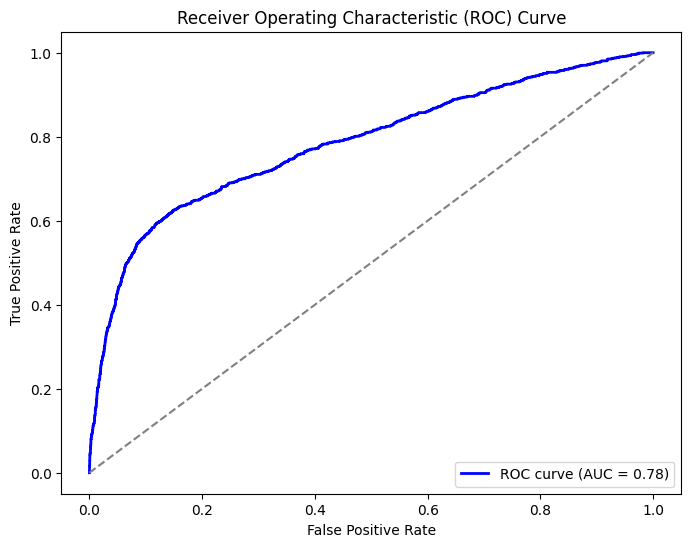

In [109]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # Use SMOTE for oversampling
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

# Assuming you have your imbalanced dataset X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the model using the best parameters from grid search
best_model = grid_search.best_estimator_

# Fit the best model on the resampled training set
best_model.fit(X_train_resampled, y_train_resampled)

# Get predicted labels and predicted probabilities for the positive class (class 1)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Assuming class 1 is the positive class

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The best models from the 3 different resampling techniques give similar results for AUC and f1-macro. The model which used SMOTE had the highest mean validation f1-macro: 0.71. Therefore this model will be taken as the best Random Forest model.